In [1]:
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize'] = [16, 9]
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth'] = 1.25
mpl.rcParams['lines.markersize'] = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from numba import jit

In [40]:

## Create the triads from the phases
@jit(nopython = True)
def compute_triads(phases, kmin, kmax):
	print("\n...Computing Triads...\n")

	## Variables
	numTriads  = 0;
	k3_range   = int(kmax - kmin + 1)
	k1_range   = int((kmax - kmin + 1) / 2)
	time_steps = phases.shape[0]

	## Create memory space
	triadphase = -10 * np.ones((k3_range, k1_range, time_steps))
	triads     = -10 * np.ones((k3_range, k1_range, time_steps))
	phaseOrder = np.complex(0.0, 0.0) * np.ones((time_steps))
	R          = np.zeros((time_steps))
	Phi        = np.zeros((time_steps))
	
	## Compute the triads
	for k in range(kmin, kmax + 1):
	    for k1 in range(kmin, int(k/2) + 1):
	        triadphase[k - kmin, k1 - kmin, :] = phases[:, k1] + phases[:, k - k1] - phases[:, k]
	        triads[k - kmin, k1 - kmin, :]     = np.mod(triadphase[k - kmin, k1 - kmin, :], 2*np.pi)

	        phaseOrder[:] += np.exp(np.complex(0.0, 1.0)*triads[k - kmin, k1 - kmin, :])
	        numTriads += 1
	
	# Compute Phase-Order params
	R[:]   = np.absolute(phaseOrder[:] / numTriads)
	Phi[:] = np.angle(phaseOrder[:] / numTriads)

	return triads, R, Phi

## Create the Kuramoto-Order from the phases
@jit(nopython = True)
def compute_phase_order(phases, amps, kmin, kmax):
    print("\n...Computing Scale Phase Order...\n")

    ## Variables
    k_range     = int(kmax - kmin + 1)
    k1_range    = int((kmax - kmin + 1) / 2)
    time_steps  = phases.shape[0]
    sum_of_amps = 0.0

    phaseOrder = -10 * np.complex(0.0, 0.0) * np.ones((time_steps, k_range))

    ## Compute the phase order
    for k in range(kmin, kmax + 1):
        for k_1 in range(kmin + k,  int(2 * kmax)):
            if k_1 < kmax:
                k1 = -kmax + k_1
            else:
                k1 = k_1 - kmax;

            if k1 < 0:
                phaseOrder[:, k - kmin] += (amps[np.absolute(k1)] * np.exp(-np.complex(0.0, 1.0) * phases[:, np.absolute(k1)])) * (amps[k - k1] * np.exp(np.complex(0.0, 1.0) * phases[:, k - k1]))
                sum_of_amps += amps[np.absolute(k1)] * amps[k - k1]
            elif k - k1 < 0:
                phaseOrder[:, k - kmin] += (amps[k1] * np.exp(np.complex(0.0, 1.0) * phases[:, k1])) * (amps[np.absolute(k - k1)] * np.exp(-np.complex(0.0, 1.0) * phases[:, np.absolute(k - k1)]))
                sum_of_amps += amps[k1] * amps[np.absolute(k - k1)]
            else:
                phaseOrder[:, k - kmin] += (amps[k1] * np.exp(np.complex(0.0, 1.0) * phases[:, k1])) * (amps[k - k1] * np.exp(np.complex(0.0, 1.0) * phases[:, k - k1]))
                sum_of_amps += amps[k1] * amps[k - k1]

    # 		phaseOrder[:, k - kmin] = (-np.complex(0.0, 1.0) * phaseOrder[:, k - kmin]) / sum_of_amps
        phaseOrder[:, k - kmin] = (-np.complex(0.0, 1.0) * phaseOrder[:, k - kmin])


    return np.absolute(phaseOrder[:, :]), np.angle(phaseOrder[:, :])



def plot_phase_order(R_k, Phi_k, kmin, kmax, t):
	
	r    = 1
	thet = np.linspace(0.0, 2.0*np.pi, 100)

	fig = plt.figure(figsize = (20, 10), tight_layout = False)
	gs  = GridSpec(1, 2)

	## REAL SPACE
	ax1 = fig.add_subplot(gs[0, 0])
	ax1.plot(r * np.cos(thet), r * np.sin(thet), '--', color = 'black')
	ax1.scatter(R_k * np.cos(Phi_k), R_k * np.sin(Phi_k), marker = 'o', c = np.arange(len(R_k)), s = 0.01, cmap = 'viridis')
	ax1.set_xlim(-1, 1)
	ax1.set_ylim(-1, 1)
	ax1.set_xlabel(r"$\Re\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
	ax1.set_ylabel(r"$\Im\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
	ax1.spines['top'].set_visible(False)
	ax1.spines['right'].set_visible(False)
	ax1.spines['bottom'].set_visible(False)
	ax1.spines['left'].set_visible(False)
	ax1.set_xticks([])
	ax1.set_yticks([])

	ax2 = fig.add_subplot(gs[0, 1])
	ax2.plot(r * np.cos(thet), r * np.sin(thet), '--', color = 'black')
	ax2.scatter(R_k * np.cos(Phi_k), R_k * np.sin(Phi_k), marker = 'o', c = np.arange(len(R_k)), s = 0.01, cmap = 'viridis')
	ax2.set_xlim(-1/5, 1/5)
	ax2.set_ylim(-1/5, 1/5)
	ax2.set_xlabel(r"$\Re\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
	ax2.set_ylabel(r"$\Im\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
	# ax2.spines['top'].set_visible(False)
	# ax2.spines['right'].set_visible(False)
	# ax2.spines['bottom'].set_visible(False)
	# ax2.spines['left'].set_visible(False)
	# ax2.set_xticks([])
	# ax2.set_yticks([])

	# plt.colorbar()
	# cbar.set_ticks([kmin, kmax/2, kmax])
 #    cbar.set_ticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])

	plt.savefig(output_dir + "/ORDER_SNAPS/Order_SNAPS_{:05d}.png".format(t), format='png', dpi = 400)  
	plt.close()


In [41]:
k0 = 1
alpha = 2.35
beta  = 0.0
iters = 400000
trans = 0
N = 256
u0 = "RANDOM"

In [42]:
results_dir = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]".format(N, k0, alpha, beta, u0)
filename    = "/LCEData_ITERS[{}]_TRANS[{}]".format(iters, trans)

######################
##	Input & Output Dir
######################
# input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Output/LCE"
# output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/TriadDynamics" + filename
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/" + results_dir

if os.path.isdir(output_dir) != True:
    os.mkdir(output_dir)
if os.path.isdir(output_dir + '/SNAPS') != True:
    os.mkdir(output_dir + '/SNAPS')
if os.path.isdir(output_dir + '/ORDER_SNAPS') != True:
    os.mkdir(output_dir + '/ORDER_SNAPS')



######################
##	Read in Input File
######################
# HDFfileData = h5py.File(input_dir + filename + '.h5', 'r')
HDFfileData = h5py.File(input_dir + results_dir + filename + '.h5', 'r')

# print input file name to screen
# print("\n\nData File: %s.h5\n" % filename)
print("\n\nData File: {}.h5\n".format(results_dir + filename))

######################
##	Read in Datasets
######################
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:]
amps   = HDFfileData['Amps'][:]




Data File: /RESULTS_N[256]_k0[1]_ALPHA[2.350]_BETA[0.000]_u0[RANDOM]/LCEData_ITERS[400000]_TRANS[0].h5



In [43]:
ntsteps = len(time);
num_osc = phases.shape[1];
N       = 2 * (num_osc - 1);
kmin    = k0 + 1;
kmax    = num_osc - 1;



######################
##	Triad Data
######################
triads, R, Phi = compute_triads(phases, kmin, kmax)
triads_exist   = 0

R_k, Phi_k = compute_phase_order(phases, amps, kmin, kmax)

print(R_k.shape)
print(Phi_k.shape)


...Computing Triads...


...Computing Scale Phase Order...

(4001, 127)
(4001, 127)


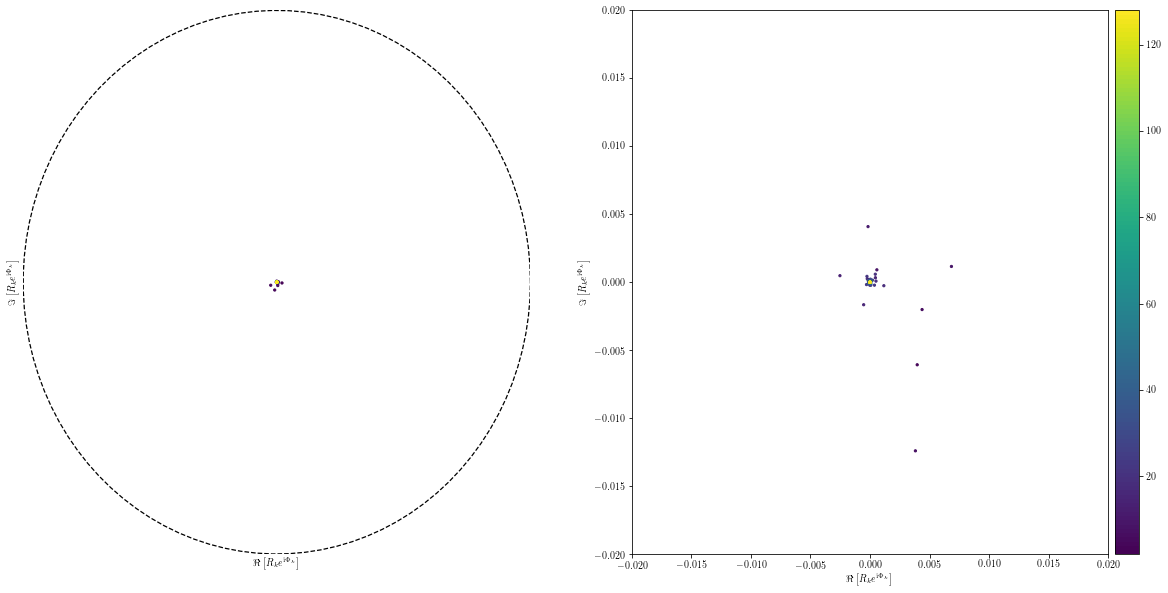

In [46]:
t = 3540
scale = 5

myvir   = cm.viridis(np.arange(255))
norm    = mpl.colors.Normalize(vmin = kmin, vmax = kmax)
my_mhsv = mpl.colors.LinearSegmentedColormap.from_list('my_map', myvir, N = (kmax - k0)) # set N to inertial range
m       = cm.ScalarMappable(norm = norm, cmap = my_mhsv)       


r    = 1
thet = np.linspace(0.0, 2.0*np.pi, 100)

fig = plt.figure(figsize = (20, 10), tight_layout = False)
gs  = GridSpec(1, 2)

## REAL SPACE
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(r * np.cos(thet), r * np.sin(thet), '--', color = 'black')
ax1.scatter(R_k[t, :] * np.cos(Phi_k[t, :]), R_k[t, :] * np.sin(Phi_k[t, :]),c = np.arange(len(R_k[t, :])), s = scale, cmap = my_mhsv)
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_xlabel(r"$\Re\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
ax1.set_ylabel(r"$\Im\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(R_k[t, :] * np.cos(Phi_k[t, :]), R_k[t, :] * np.sin(Phi_k[t, :]),c = np.arange(len(R_k[t, :])), s = scale, cmap = my_mhsv)
ax2.set_xlim(-1/50, 1/50)
ax2.set_ylim(-1/50, 1/50)
ax2.set_xlabel(r"$\Re\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
ax2.set_ylabel(r"$\Im\left[R_{k} e^{\mathrm{i} \Phi_{k}}\right]$")
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)
# ax2.set_xticks([])
# ax2.set_yticks([])

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size = '5%', pad = 0.1)
cbar2 = mpl.colorbar.ColorbarBase(cax2, cmap = my_mhsv, norm = norm)
# cbar2.set_ticks([0.0, kmax/2, kmax])
# cbar2.set_ticklabels([r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"])
plt.show()

In [47]:
print(R_k[t, :] == 2.06835783e-02)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


In [48]:
alpha

2.35

In [17]:
kmax - k0


127

In [78]:
aa = np.arange(0.0, 3.5, 0.05)

In [51]:
aa[aa == .25]

array([0.25])

In [52]:
aa[4]

0.2

In [54]:
np.extract(aa == .25, aa)

array([0.25])

In [55]:
norm = mpl.colors.Normalize(vmin = np.array(alpha).min(), vmax = np.array(alpha).max())
cmap = mpl.cm.ScalarMappable(norm = norm, cmap = mpl.cm.viridis)
cmap.set_array([])

In [68]:
cmap.to_rgba()

array([[0.267004, 0.004874, 0.329415, 1.      ]])

In [62]:
type(cmap.to_rgba(aa[4]))

tuple

In [66]:
map(tuple, cmap.to_rgba(np.extract(aa == .25, aa)))

In [69]:
tuple(np.extract(aa == .25, aa))

(0.25,)

In [71]:
cmap.to_rgba((0.25,))

array([[0.267004, 0.004874, 0.329415, 1.      ]])

In [74]:
np.extract(aa == .25, aa)[0]

0.25

In [77]:
aa[aa == 0.25][0]

0.25

In [91]:
aa[x]

array([1.  , 1.15, 1.3 , 1.45, 1.6 , 1.75, 1.9 , 2.05])

In [84]:
tuple(range(19, 41, 3))

(19, 22, 25, 28, 31, 34, 37, 40)

In [90]:
x = np.arange(20, 42, 3)
x

array([20, 23, 26, 29, 32, 35, 38, 41])